In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd
import scipy as sp

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
df = pd.read_csv('newdata.csv')
print(df.info())
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encode categorical features
label_encoders = {}
for column in ['Category', 'Sub_category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
label_encoders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          500 non-null    int64  
 1   Product_Name        500 non-null    object 
 2   Category            500 non-null    object 
 3   Sub_category        500 non-null    object 
 4   Price               500 non-null    float64
 5   Rating              500 non-null    float64
 6   No_rating           500 non-null    int64  
 7   Discount            500 non-null    float64
 8   M_Spend             500 non-null    float64
 9   Supply_Chain_E      500 non-null    float64
 10  Sales_y             500 non-null    int64  
 11  Sales_m             500 non-null    int64  
 12  Market_T            500 non-null    float64
 13  Seasonality_T       500 non-null    float64
 14  Success_Percentage  500 non-null    float64
dtypes: float64(8), int64(4), object(3)
memory usage: 58.7+ KB

{'Category': LabelEncoder(), 'Sub_category': LabelEncoder()}

In [3]:
X = df.drop(['Product_Name', 'Success_Percentage', 'Unnamed: 0'], axis=1)
y = df['Success_Percentage']

<Axes: xlabel='Success_Percentage', ylabel='Density'>

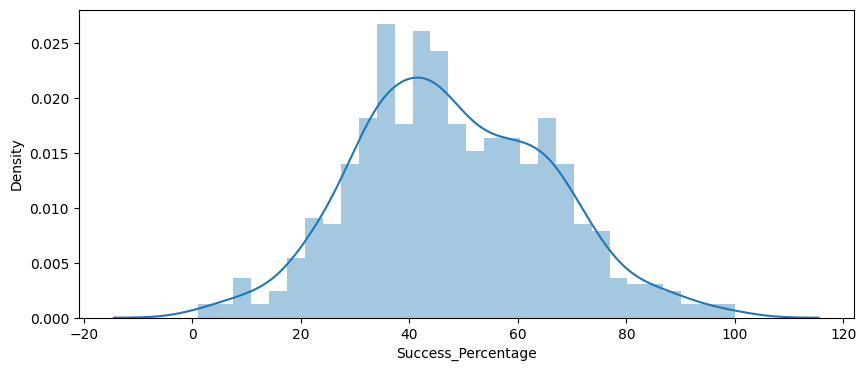

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(df['Success_Percentage'], bins=30, kde=True, ax=ax)

In [5]:
num_feat = [x for x in df.columns if df[x].dtype !="object"]

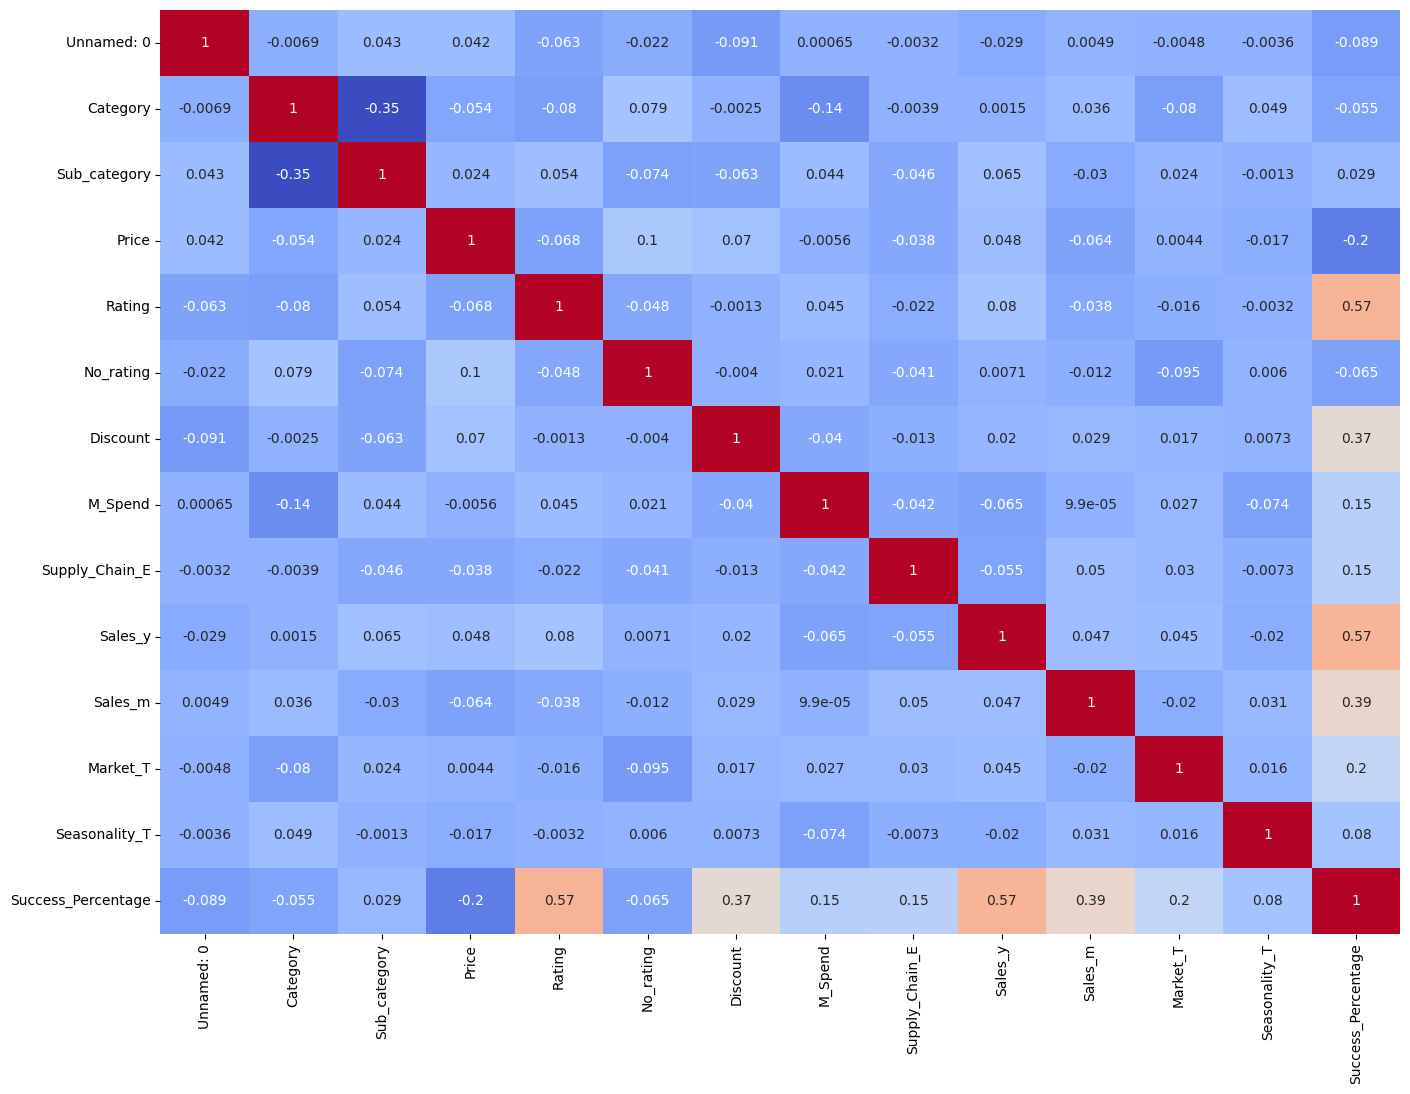

In [6]:
# Correlation between numerical variables
corr_matrix = df[num_feat].corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix.T, annot=True, cbar=False, cmap='coolwarm');

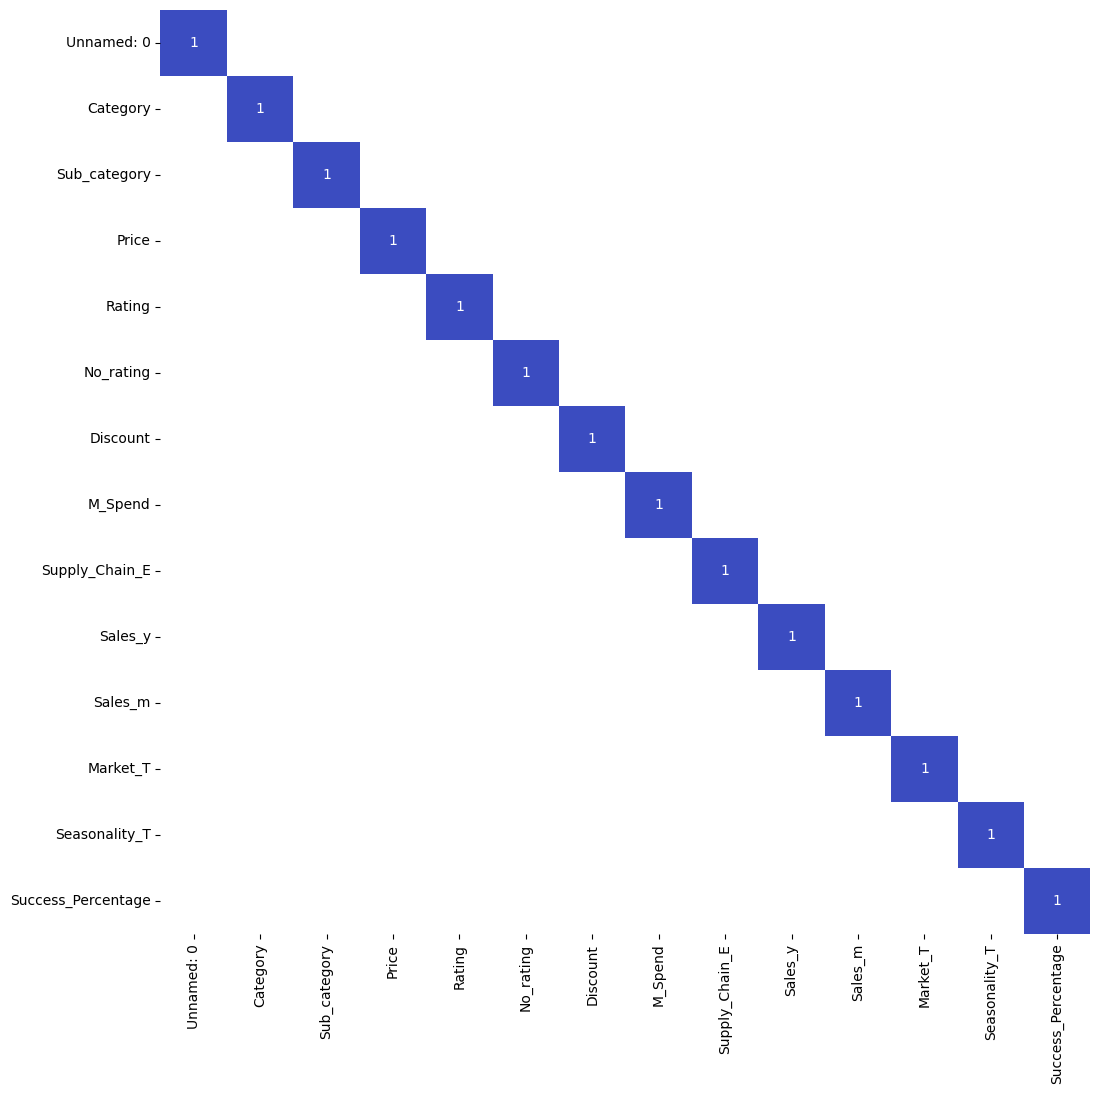

In [7]:
# Correlated variables greater than 0.8
corr_matrix = df[num_feat].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix.T, annot=True, mask= corr_matrix < 0.8 ,cbar=False, cmap='coolwarm');

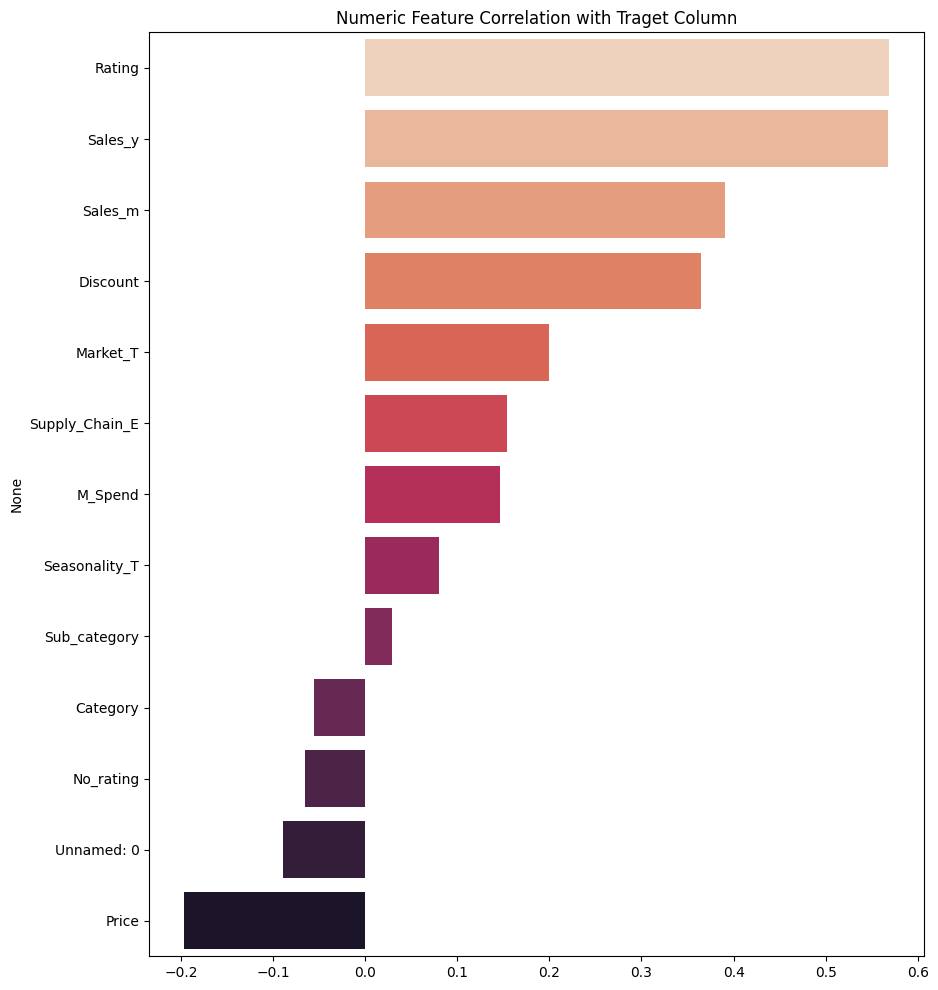

In [8]:
price_corr_ser = df[num_feat].corr()['Success_Percentage']
price_corr_ser = price_corr_ser.sort_values(ascending=False)
price_corr_ser = price_corr_ser.drop("Success_Percentage")

fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=price_corr_ser.values, y=price_corr_ser.index, palette="rocket_r")
plt.title("Numeric Feature Correlation with Traget Column");

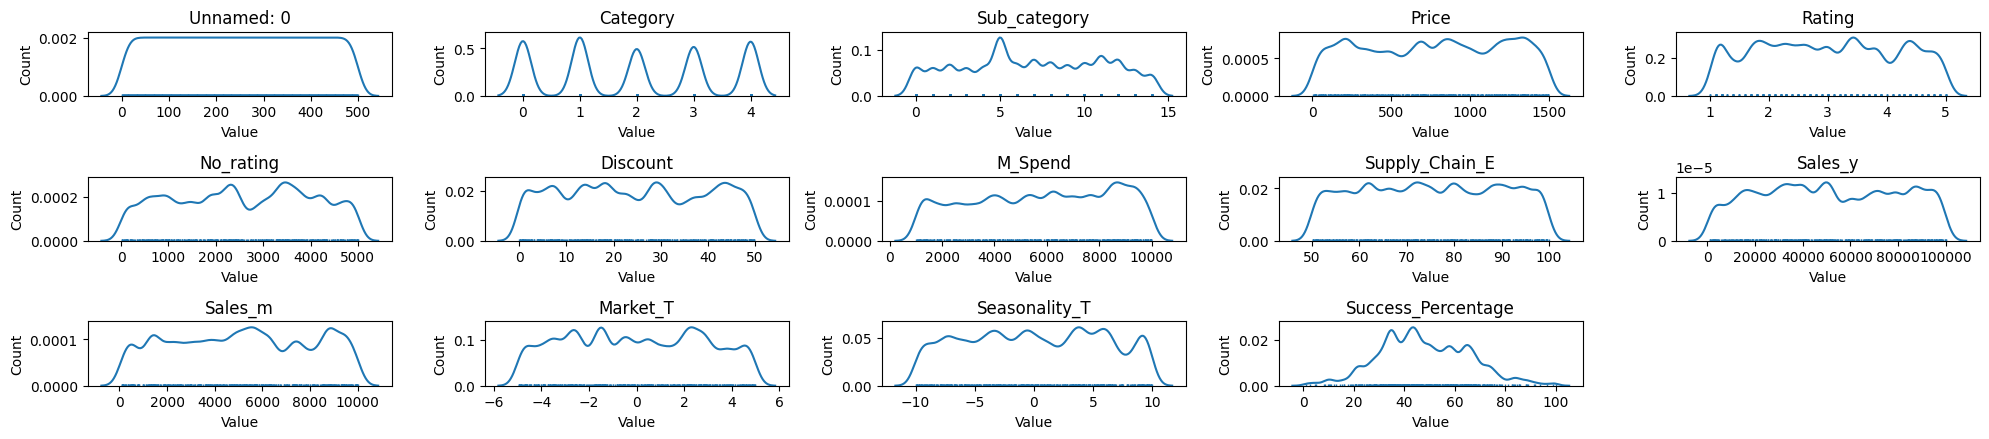

In [9]:
# Plot distribution of numeric variables
fig = plt.figure(figsize=(20,20))

for i in range(len(num_feat)):
    plt.subplot(14,5, i+1)
    sns.distplot(df[num_feat[i]], rug=True, hist=False, kde_kws={'bw':0.1})
    plt.title(num_feat[i])
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
fig.show()

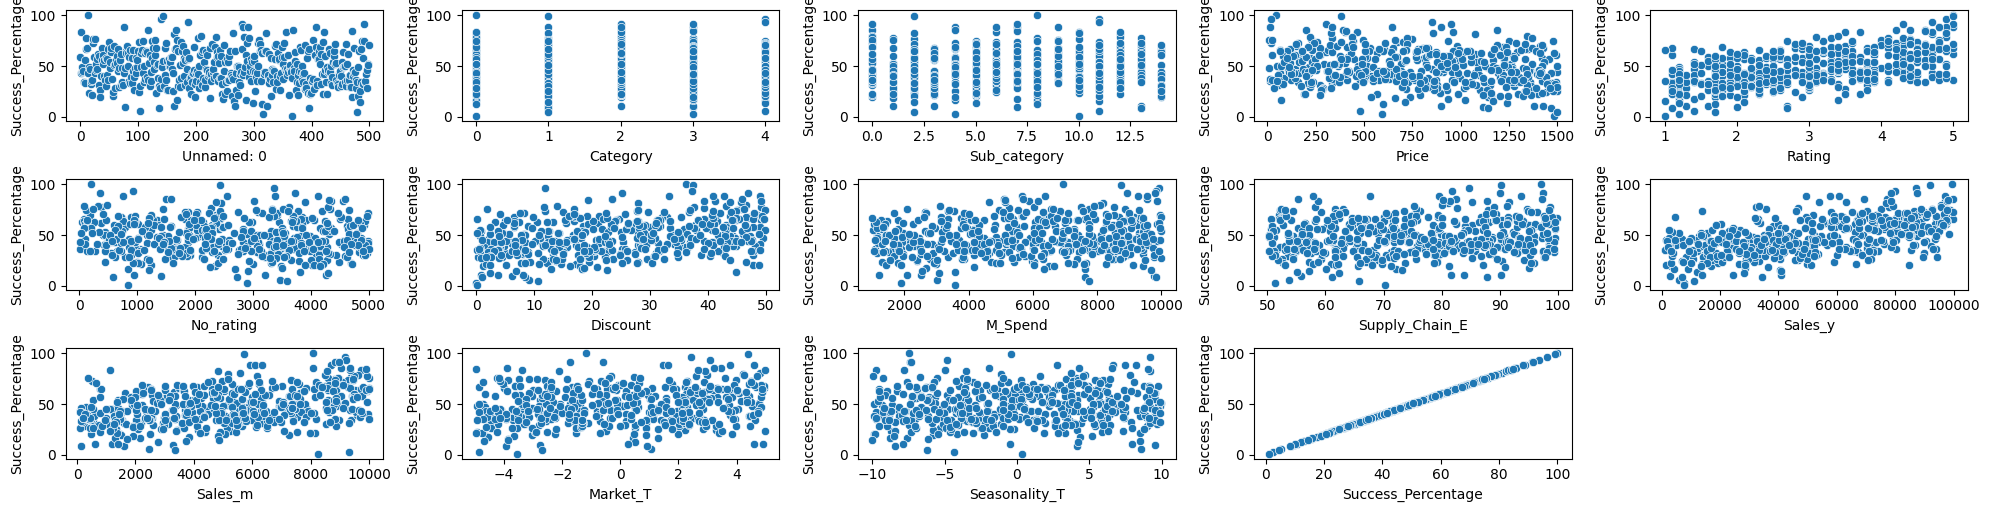

In [10]:
# Visualize relation between numeric features and target column
fig = plt.figure(figsize=(20,20))
# numeric_df = num_df.drop('SalePrice', axis=1)

for i, col in enumerate(df[num_feat].columns):
    plt.subplot(12,5, i+1)
    sns.scatterplot(x=df[col], y=df['Success_Percentage'])
    plt.tight_layout()
    
fig.show()

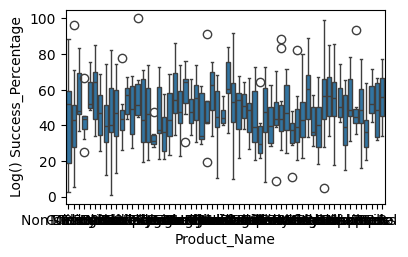

In [11]:
# List of categorical columns
cat_feat = [x for x in df.columns if df[x].dtype == "object"]

# Create a multi plot with categorical features
fig = plt.figure(figsize=(18, 30))

for i , col in enumerate(cat_feat):
    plt.subplot(12,5, i+1)
    sns.boxplot(x=col, y='Success_Percentage', data=df)
    plt.ylabel("Log() Success_Percentage")
    plt.tight_layout()
    
fig.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encode categorical features
label_encoders = {}
for column in ['Category', 'Sub_category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
label_encoders

{'Category': LabelEncoder(), 'Sub_category': LabelEncoder()}

In [15]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# Create function for model evaluation
def model_evaluation(algo,algoname):
    """
    This function  fit and  evaluate 
    given algorithm. It takes 3 arguments:
    
    First: algorithm of a choice without parentheses.
    Second: the name of a algorithm as a string.
    """

    # Fit given model
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # R-squared 
    r2score = r2_score(y_test, y_pred)
    
    print(f"**{algoname} Metrics**")
    print(f"**MAE: {mae:}")
    print(f"**RMSE: {rmse:}")
    
    return mae, rmse, r2score, y_pred, algo

<h1 align = "center">SGDRegressor</h1>

<h1 align = "center">SGDRegressor</h1>

In [16]:
# Create a base model
from sklearn.linear_model import SGDRegressor

sgd_base_model = SGDRegressor(random_state=101)

sgd_base_mae, sgd_base_rmse, sgd_base_r2score, sgd_y_pred, _ = model_evaluation(sgd_base_model, 
                                                                                "SGDRegressor")

**SGDRegressor Metrics**
**MAE: 5.561910394758875e+17
**RMSE: 5.953129236318509e+17


<h1 align = "center">SGD Regressor</h1>

In [18]:
def plot_residuals(y_pred, algoname):
    """
    Function plots probability and residuals plot
    """
    residuals = pd.Series(y_test - y_pred, 
                          name="residuals")
    
    fig, axes = plt.subplots(ncols=2, 
                             nrows=2, 
                             figsize=(14,4), 
                             dpi=120)
    # Plot probability
    sp.stats.probplot(residuals, plot=axes[0,0])
    # Plot kde
    sns.distplot(residuals, ax=axes[0,1], hist=False)
    # Plot residuals
    sns.scatterplot(x=y_test, y=residuals, ax=axes[1,0])
    axes[1,0].axhline(y=0, c='red',ls='--')
    # Plot distribution
    sns.boxplot(residuals, ax=axes[1,1])
    plt.tight_layout()

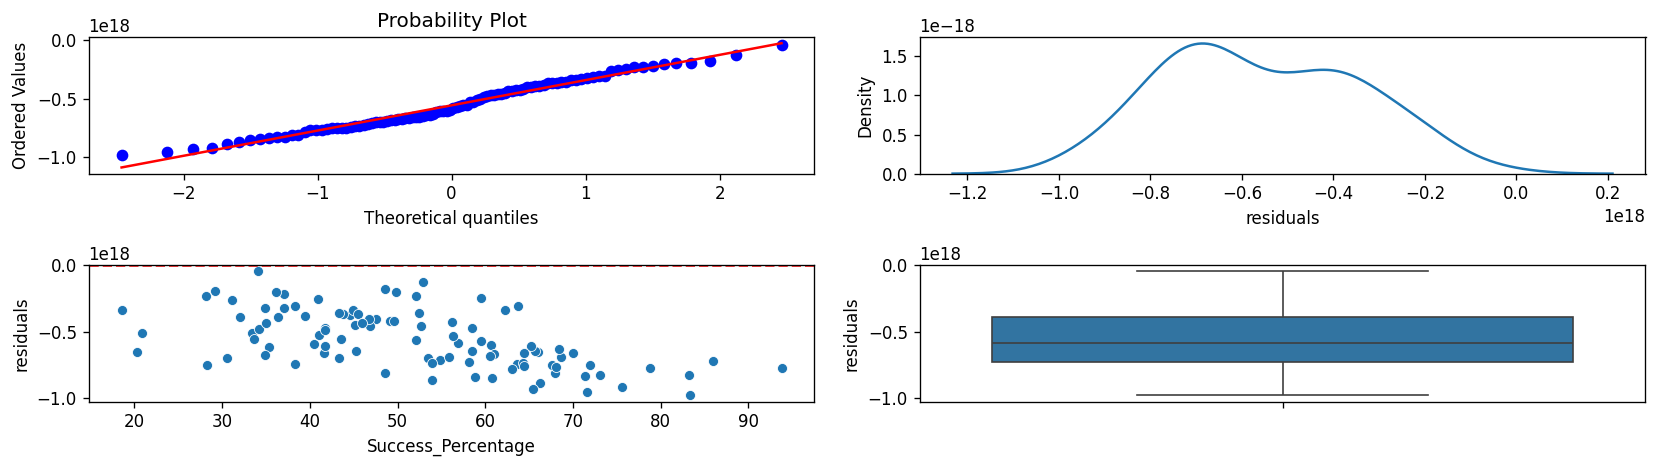

In [19]:
plot_residuals(sgd_y_pred, "SGDRegressor")

<h1 align = "center"> Gradient Boosting Regressor </h1>

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()
gbr_base_mae, gbr_base_rmse, gbr_base_r2score, gbr_y_pred, gbr_model = model_evaluation(gbr_model, 
                                                                                        "GradientBostingRegressor")

**GradientBostingRegressor Metrics**
**MAE: 3.7588594702990723
**RMSE: 4.708959373041595


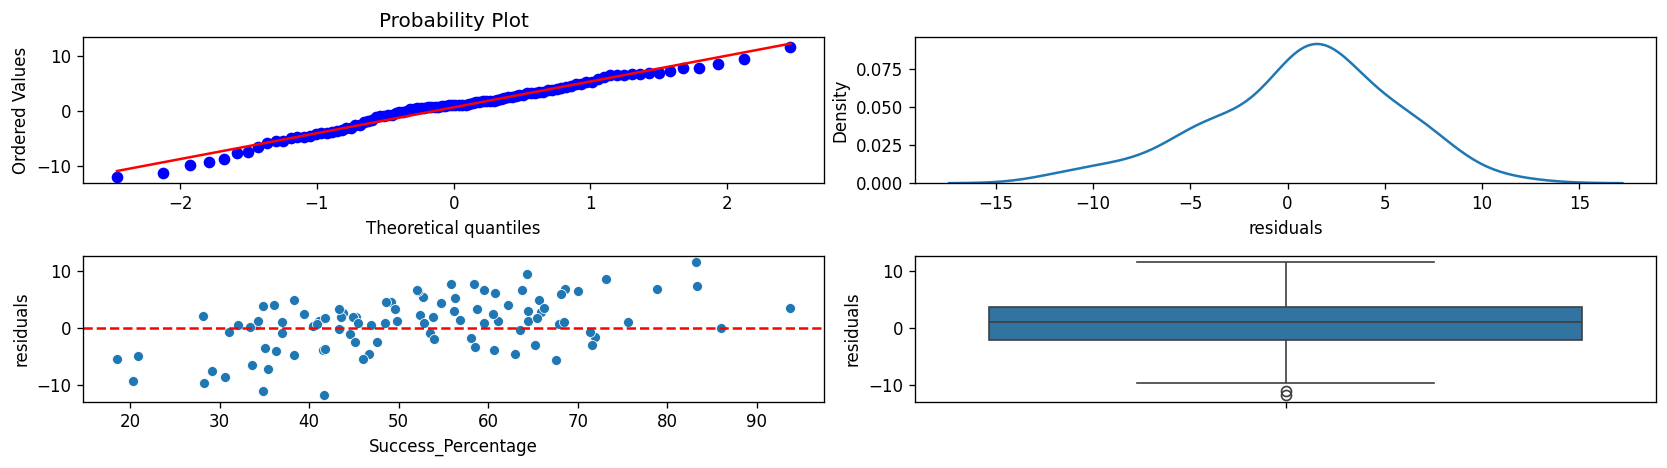

In [22]:
plot_residuals(gbr_y_pred, "GradientBostingRegressor")

<h1 align = "center"> Random Forest Regressor </h1>

In [23]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor()
rfr_base_mae, rfr_base_rmse, rfr_base_r2score, rfr_y_pred, rfr_model = model_evaluation(rfr_model, 
                                                                                        "RandomForestRegressor")

**RandomForestRegressor Metrics**
**MAE: 5.574012384680061
**RMSE: 7.0706498109274465


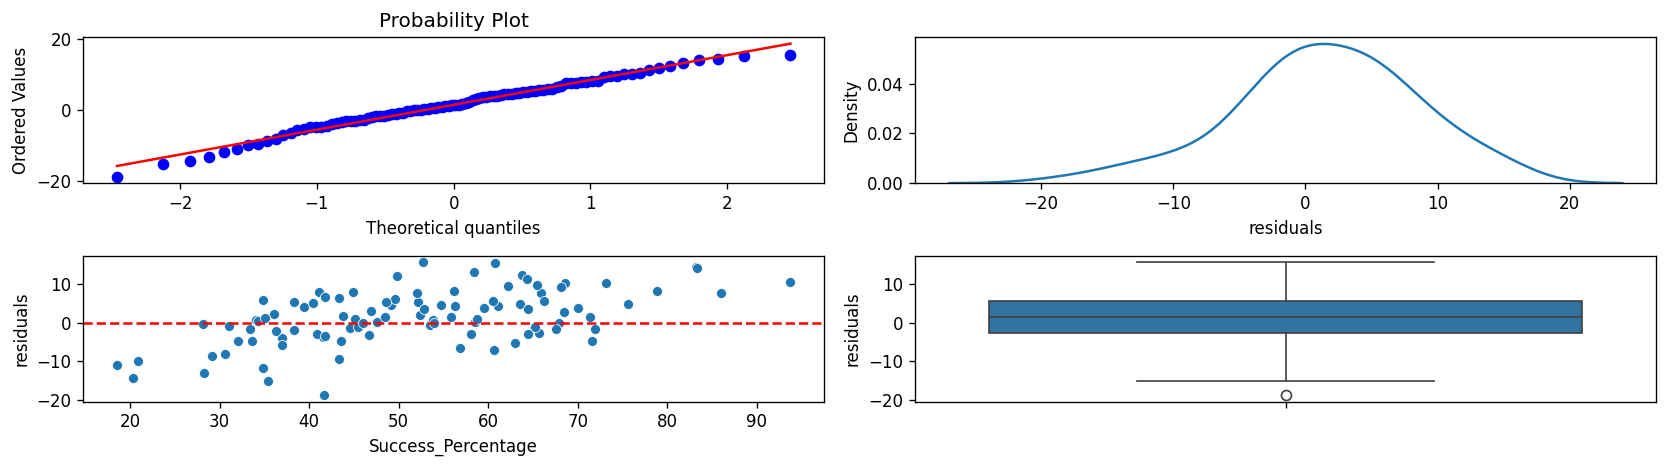

In [24]:
plot_residuals(rfr_y_pred, "Random Forest Regressor")

<h1 align = "center"> XGBRegressor </h1>

In [25]:
from xgboost import XGBRegressor

xgboost_model = XGBRegressor()
xgboost_base_mae, xgboost_base_rmse, xgboost_base_r2score, xgboost_y_pred, xgboost_model = model_evaluation(xgboost_model, 
                                                                                                            "Extreme Gradient Boosting")

**Extreme Gradient Boosting Metrics**
**MAE: 5.059614052104113
**RMSE: 6.28948356706616


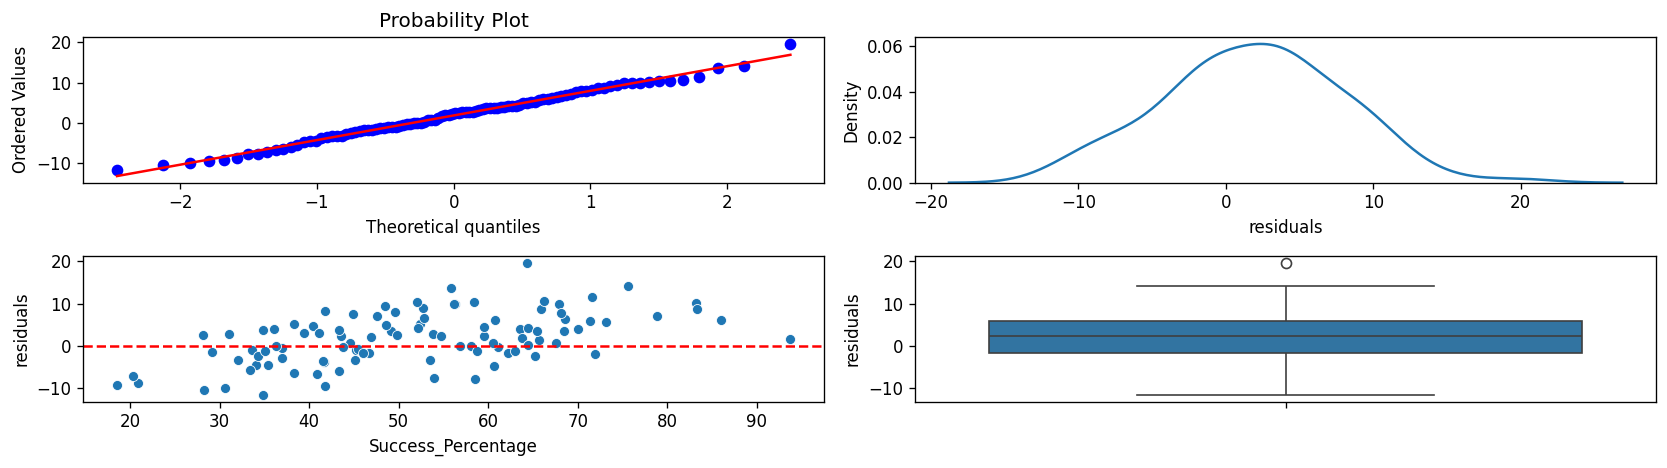

In [26]:
plot_residuals(xgboost_y_pred, "Extreme Gradient Boosting")

<h1 align = "center"> Gradient Boosting Regressor </h1>

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_base_mae, knn_base_rmse, knn_base_r2score, knn_y_pred, knn_model = model_evaluation(knn_model, 
                                                                                        "KNeighborsRegressor")

**KNeighborsRegressor Metrics**
**MAE: 10.42280803973485
**RMSE: 13.124567247007999


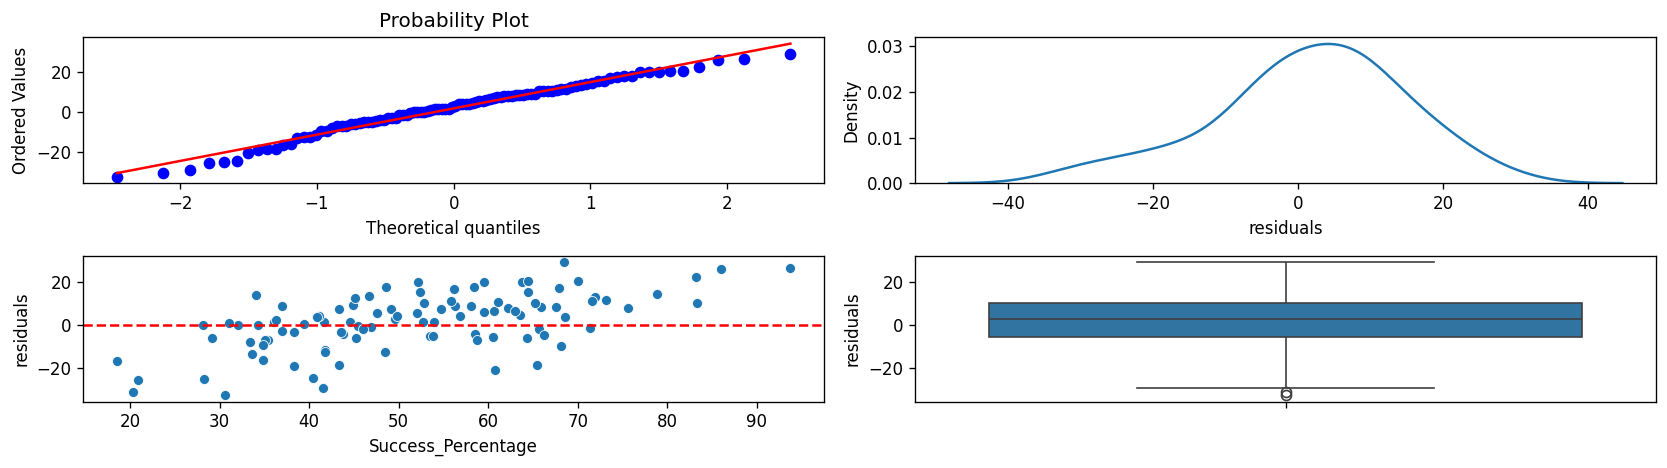

In [28]:
plot_residuals(knn_y_pred, "KNeighborsRegressor")

<h1 align = "center"> ElasticNetCV </h1>

In [29]:
from sklearn.linear_model import ElasticNetCV

elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])

el_base_mae, el_base_rmse, el_base_r2score, el_base_y_pred, elastic_model = model_evaluation(elastic_model,
                                                                                             "ElasticNetCV")

**ElasticNetCV Metrics**
**MAE: 8.666287344555645
**RMSE: 10.987084578559578


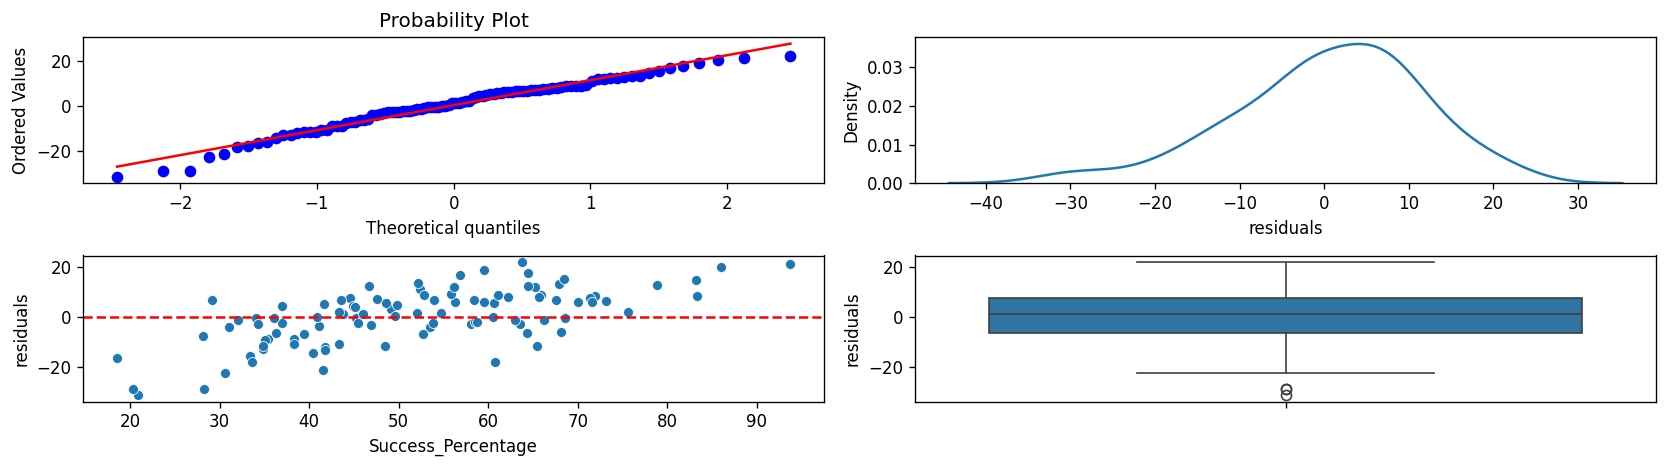

In [30]:
plot_residuals(el_base_y_pred, "ElasticNetCV")

In [31]:
elastic_model.l1_ratio_

1.0

<h1 align = "center"> LassoCV </h1>

In [32]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(eps=0.01, n_alphas=200, cv=10, max_iter=1000000)


lassoCV_mae, lassoCV_rmse, lassoCV_r2score, lassoCV_y_pred, lasso_cv_model = model_evaluation(lasso_cv_model, "LassoCV")

**LassoCV Metrics**
**MAE: 9.020838613201324
**RMSE: 11.375182462624563


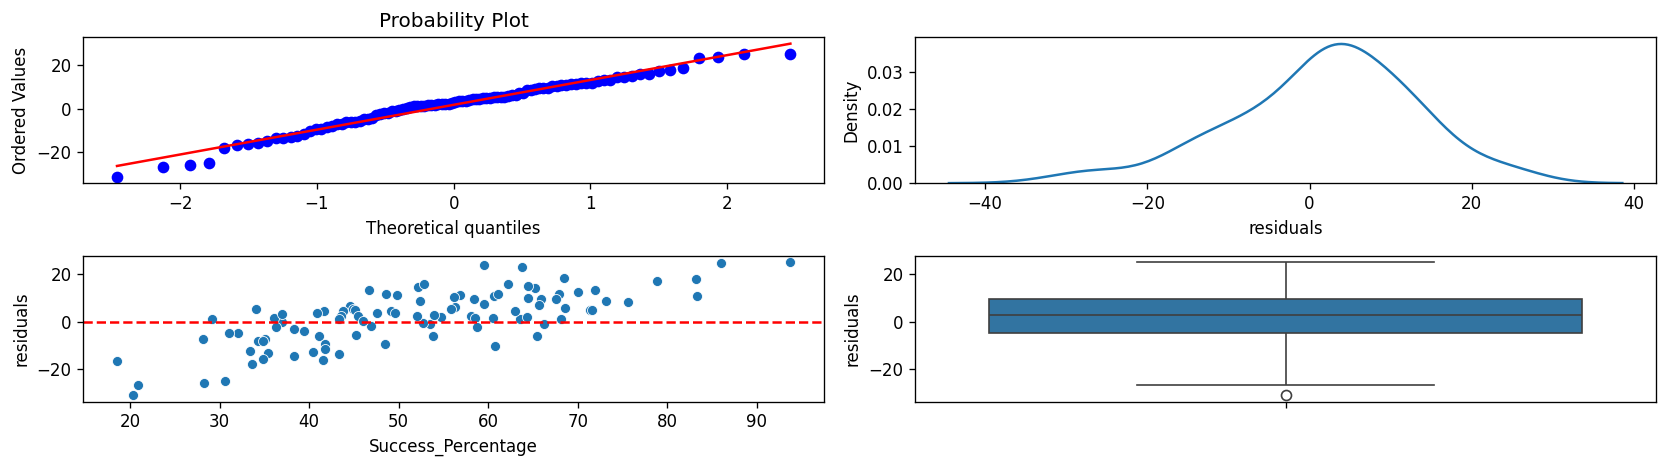

In [33]:
plot_residuals(lassoCV_y_pred, "LassoCV")

<h1 align="center"> RidgeCV </h1>

In [35]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_cv_mae, ridge_cv_rmse, ridge_cv_r2, ridge_cv_y_pred, ridge_model = model_evaluation(ridge_model,
                                                                                          "RidgeCV")

**RidgeCV Metrics**
**MAE: 0.0017685733550976935
**RMSE: 0.0021826819121170122


In [36]:
from sklearn.svm import SVR

svr_base_model = SVR()

svr_base_mae, svr_base_rmse, svr_base_r2score, svr_base_y_red, svr_base_model = model_evaluation(svr_base_model, 
                                                                                                 "Support Vector Regressor")

**Support Vector Regressor Metrics**
**MAE: 10.409818429692198
**RMSE: 13.256986329553227


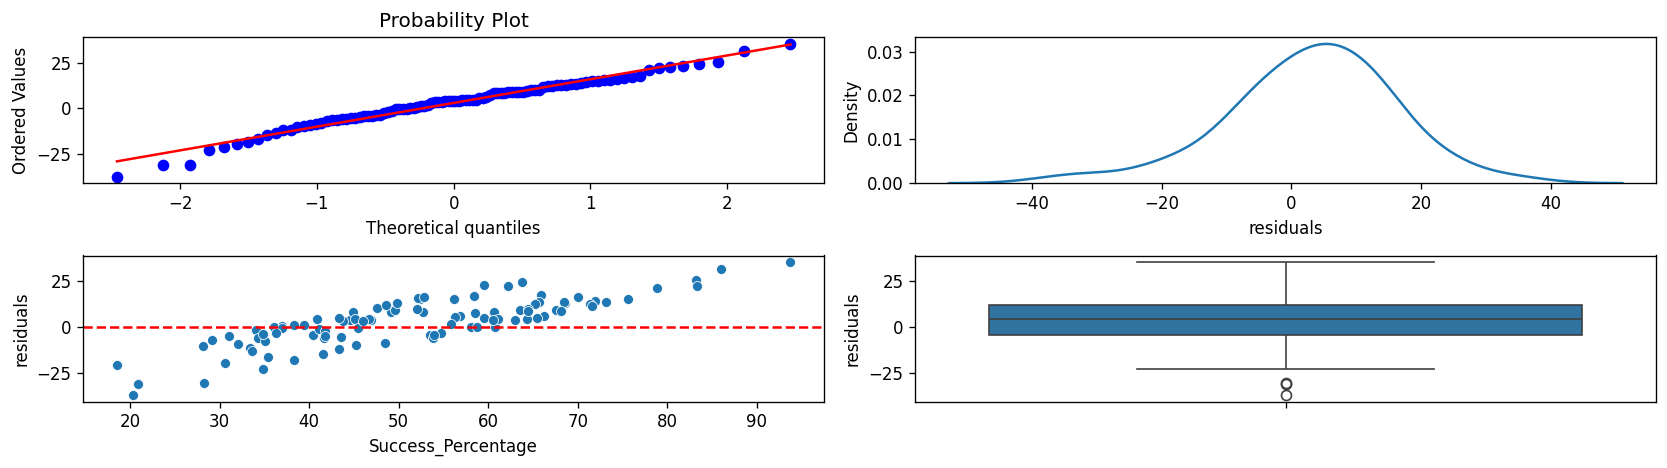

In [37]:
plot_residuals(svr_base_y_red, "SVR")

In [125]:
from catboost import CatBoostRegressor

cat_base = CatBoostRegressor(verbose=0, random_state=101)

cat_base_mae, cat_base_rmse, cat_base_r2, cat_base_y_pred, cat_base_model = model_evaluation(cat_base,
                                                                                             "CatBoostRegressor")

**CatBoostRegressor Metrics**
**MAE: 2.319117081511945
**RMSE: 2.9801633263517084
**R-squared: 0.96%
